In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math

from statsmodels.tsa.stattools import adfuller

from joblib import Parallel, delayed
from sklearn import preprocessing

from scipy.signal import argrelextrema
from datetime import datetime
import shutil

from collections import Counter
from scipy import stats
import statistics

from sklearn.preprocessing import MinMaxScaler

In [4]:
total_path =  'C:\\Users\\Алексей\\Магистратура ФТИАД\\Курсовая\\Данные\\Дневные'

ts_path = total_path + '\\Train_and_Test-1\\TS (все)'
save_path = total_path + '\\Train_and_Test-1\\TS (приращения)'

In [5]:
os.chdir(total_path)

In [7]:
def check_ts(ticker):
    # функция проверки приращений
    
    res_df = pd.DataFrame()
    ticker_name = ticker
    res = {}
    res['Ticker'] = ticker_name[:-5]
    ts_df = pd.read_excel(ts_path+'\\'+ticker_name)
    ts_df = ts_df[['Date','Adj Close']]
    diff_ts_df = ts_df.diff(periods=1).dropna()

    if all([i > 0 for i in list(diff_ts_df['Adj Close'])]):
        res['Результат'] = 'все приращения положительные'
        res_df = res_df.append(res, ignore_index = True)
    elif all([i < 0 for i in list(diff_ts_df['Adj Close'])]):
        res['Результат'] = 'все приращения отрицательные'
        res_df = res_df.append(res, ignore_index = True)
    else:
        res['Результат'] = 'есть и положительные, и отрицательные приращения'
        res_df = res_df.append(res, ignore_index = True)
        ts_df.to_csv(ticker_name[:-5]+'.csv', index = False)
        file_name = ticker_name[:-5]+'.csv'
        os.replace(total_path + '\\'+  file_name, save_path + '\\'+  file_name)
    return res

In [8]:
def find_extremums(me, num_points):
    
    # функция ищет точки смены тренда для конкретного временного ряда file. Принимает: 
    # me - ряд.
    # num_points - число точек, которые отступаем от экстремума для удаления шума 
    # Возвращает: индексы точек и значения ряда в них.
    left = me[0]
    right = me[-1]
    
    idx_minimas = argrelextrema(me, np.less_equal, order=num_points)[0]
    idx_maximas = argrelextrema(me, np.greater_equal, order = num_points)[0]
    idx = list(np.sort(np.concatenate((idx_minimas, idx_maximas))))
    list_exterem = list(me[idx])
    
    if left in list_exterem:
        idx_l = list_exterem.index(left)
        list_exterem.remove(left)
        del idx[idx_l]
        
    if right in list_exterem:
        idx_r = list_exterem.index(right)
        list_exterem.remove(right)
        del idx[idx_r]
        
    return {'extrem_index': idx, 'extrem_value': list_exterem}

In [7]:
def cacl_extrem_for_one_ticker(ticker, noise_size):
        
        # читает тикер, возвращает список экстремумов со значением ряда в этих точках.
        
        ts_df = pd.read_csv(ts_path+'\\'+ticker)
        extrem_dict = find_extremums(np.array(ts_df['Adj Close']), noise_size)
        res_df = ts_df[ts_df.index.isin(extrem_dict['extrem_index'])]
        res_df = res_df.reset_index()
        res_df['Ticker'] = ticker[:-4]
        res_df = res_df[['Ticker','Date','index','Adj Close']]
        res_df['Value'] = res_df['Adj Close']
        del res_df['Adj Close']
        
        if len(res_df) == 0:
            res_df = res_df.append({'Ticker': ticker},ignore_index=True)
        return res_df

In [9]:
def split_list(df_list, sub_size):
    n_parts = math.ceil(len(df_list)/sub_size)
    res = []
    res.append(df_list[:sub_size])
    for i in range(1, n_parts - 1):
        res.append(df_list[sub_size*i:sub_size*(i+1)])

    res.append(df_list[sub_size*(i+1):])

    return res

#### проверка по приращениям

In [6]:
dir_list = os.listdir(ts_path)

In [6]:
%%time
total_res = Parallel(n_jobs=4)(delayed(check_ts)(j) for j in dir_list)

Wall time: 15h 39min 32s


In [7]:
total_res_df = pd.DataFrame(columns = ['Ticker', 'Результат'])
for i in total_res:
    total_res_df = total_res_df.append(i, ignore_index=True)

In [8]:
total_res_df.to_excel('Статистика по приращениям Train_Test_1.xlsx', index = False)

#### проверим на Nan

In [9]:
ts_path = total_path + '\\Train_and_Test-1\\TS (приращения)'
save_path = total_path + '\\Train_and_Test-1\\TS (приращения, нормализация)'

In [10]:
dir_list = os.listdir(ts_path)
interr_list = []

In [13]:
%%time
for j in dir_list:
        ts_df = pd.read_csv(ts_path+'\\'+j)
#         ts_df = clear_from_NaN(ts_df)
#         result = {}
        if ts_df.isnull().sum()[1] > 0:
            print(j)
            interr_list.append(j)

Wall time: 24min 27s


#### пусто, найдем экстремумы

In [153]:
ts_path = total_path + '\\Train_and_Test-1\\TS (приращения)'
dir_list = os.listdir(ts_path)

In [17]:
noise_size = 83 # число дней для подавления шума

In [11]:
%%time
total_res = Parallel(n_jobs=4)(delayed(cacl_extrem_for_one_ticker)(j, noise_size) for j in dir_list)

Wall time: 20min 31s


In [12]:
for i in total_res:
    if len(i)==0:
        print(i)

In [17]:
def sub_func(res_list, num_of_part):
    total_res_df = pd.DataFrame(columns = ['Ticker','Date','index','Value'])
    for i in res_list:
        total_res_df = total_res_df.append(i)
    total_res_df.to_csv('part_'+str(num_of_part)+'.csv', index = False)    

In [18]:
res_split = split_list(total_res, 2500)

In [19]:
stop_flag = False
for i in range(0,len(res_split)):
    block = res_split[i]
    for j in range(0,len(block)):
        if (block[j].loc[0]['Ticker'] != total_res[i*2500+j].loc[0]['Ticker']):
            print(total_res[k+j].loc[0]['Ticker'])
            print(el[j].loc[0]['Ticker'])
            print('?????????????????????????????????')
            stop_flag = True
            break
    if stop_flag == True:
        break

In [20]:
a = 0
for i in res_split:
    a+=len(i)

In [21]:
a==len(total_res)

True

In [22]:
len(np.arange(0,51)) == len(res_split)

True

In [23]:
%%time
os.chdir(total_path)
os.mkdir('sub_folder') # раскомменть, если папки нет
os.chdir(total_path + '\\sub_folder')

Parallel(n_jobs=4)(delayed(sub_func)(res_split[j], j) for j in range(0,51))

Wall time: 7min 27s


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### очистим от ступенчатости

In [25]:
os.chdir(total_path + '\\sub_folder')
for i in range(0,51):
    df = pd.read_csv('part_'+str(i)+'.csv')
    tickers_sublist = list(df['Ticker'].unique())
    corr_tickers = []
    for j in tickers_sublist:
        sub_df = df[df['Ticker']==j]
        sub_df['Value-1'] = sub_df['Value'].shift(1)
        sub_df['Diff']= sub_df['Value'] - sub_df['Value-1']
        if all(sub_df['Diff']!=0):
            corr_tickers.append(j)

    df = df[df['Ticker'].isin(corr_tickers)]
#     del df['Unnamed: 0']
    df.to_csv('part_'+str(i)+'_clear.csv', index = False)

C:\Users\CD86~1\AppData\Local\Temp/ipykernel_9480/2137636852.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Value-1'] = sub_df['Value'].shift(1)
C:\Users\CD86~1\AppData\Local\Temp/ipykernel_9480/2137636852.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['Diff']= sub_df['Value'] - sub_df['Value-1']


In [31]:
%%time

days_l_list = []
index_l_list = []
os.chdir(total_path + '\\sub_folder')
for i in range(0,51):
    df = pd.read_csv('part_'+str(i)+'_clear.csv')
    df = df.dropna()
    tickers_sublist = list(df['Ticker'].unique())
    len_list = []
    for j in tickers_sublist:
        sub_df = df[df['Ticker']==j]
        sub_df['Date'] = pd.to_datetime(sub_df['Date'])
        sub_df['Date-1'] = sub_df['Date'].shift(1)
        sub_df['Diff']= sub_df['Date'] - sub_df['Date-1']

        days_l = list(sub_df['Diff'].dropna().dt.days)

        sub_df['index-1'] = sub_df['index'].shift(1)
        sub_df['Diff']= sub_df['index'] - sub_df['index-1']

        index_l = list(sub_df['Diff'].dropna())
        days_l_list.append(days_l)
        index_l_list.append(index_l)

<timed exec>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Wall time: 1min 36s


#### построим статистику по длинам трендов (по индексу ряда и по каледарным дням)

In [63]:
days_l_list_full = []
for i in days_l_list:
    days_l_list_full = days_l_list_full + i
    
index_l_list_full = []
for i in index_l_list:
    index_l_list_full  = index_l_list_full + i

In [64]:
total_n = len(days_l_list_full)

len(days_l_list_full) == len(index_l_list_full)

True

In [65]:
n = 5

In [66]:
index_l_list_full_short = [i for i in index_l_list_full if i <800]
days_l_list_full_short = [i for i in days_l_list_full if i <800]

In [67]:
index_l_list_full_short = [n * round(i/n) for i in index_l_list_full_short]
days_l_list_full_short= [n * round(i/n) for i in days_l_list_full_short]


Статистика по индексу TS:
10 квантиль = 36.0
25 квантиль = 64.0
медиана = 107.0
75 квантиль = 168.0
80 квантиль = 191.0
Всего образцов трендов 352236
2 квантиль = 21.0


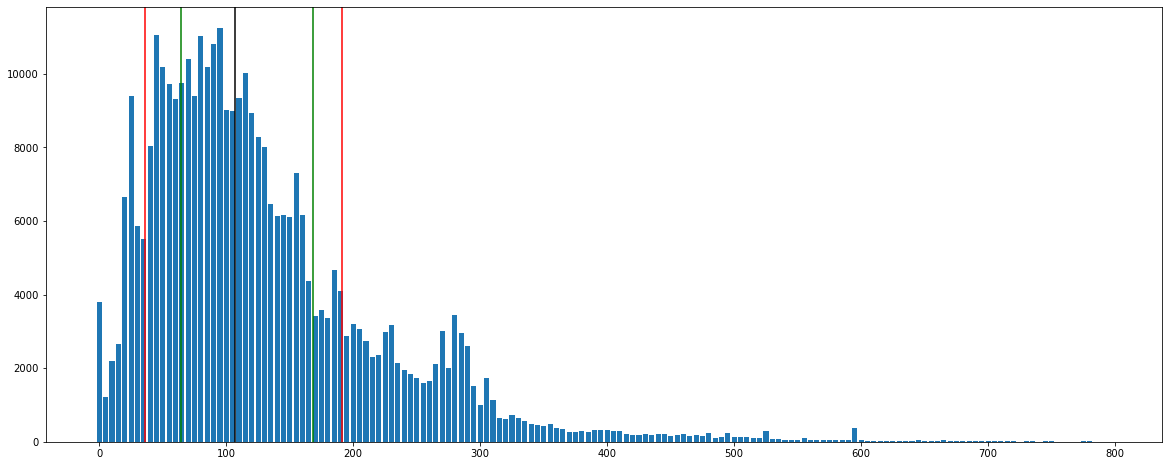

In [151]:
c = Counter(index_l_list_full_short)

x = list(c.keys())
y = list(c.values())

median = statistics.median(index_l_list_full)
line_25 = np.quantile(index_l_list_full, 0.25)
line_75 = np.quantile(index_l_list_full, 0.75)
line_80 = np.quantile(index_l_list_full, 0.8)
line_10 = np.quantile(index_l_list_full, 0.1)
line_04 = np.quantile(index_l_list_full, 0.04)

plt.figure(figsize=(20,8))
plt.bar(x,y, width= 4)
plt.axvline(x=median, c = 'black')
plt.axvline(x=line_25, c = 'green')
plt.axvline(x=line_75, c = 'green')
plt.axvline(x=line_80, c = 'red')
plt.axvline(x=line_10, c = 'red')

print('Статистика по индексу TS:')
print('10 квантиль = '+str(line_10) )
print('25 квантиль = '+str(line_25) )
print('медиана = '+str(median) )
print('75 квантиль = '+str(line_75) )
print('80 квантиль = '+str(line_80) )
print('Всего образцов трендов '+str(total_n))


print('2 квантиль = '+str(line_02) )

Статистика по дням:
10 квантиль = 53.0
25 квантиль = 93.0
медиана = 157.0
75 квантиль = 251.0
80 квантиль = 286.0
Всего образцов 352236


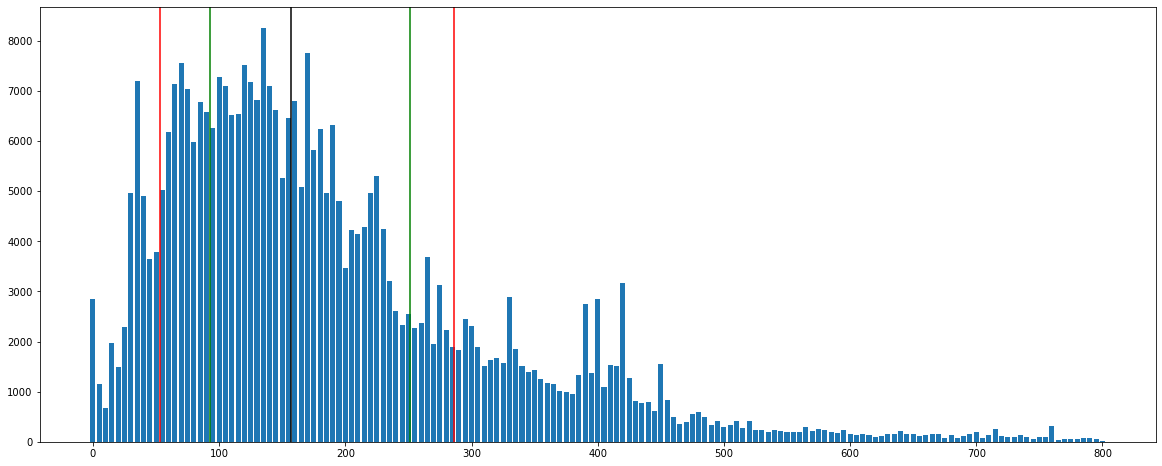

In [74]:
c = Counter(days_l_list_full_short)

x = list(c.keys())
y = list(c.values())

median = statistics.median(days_l_list_full )
line_25 = np.quantile(days_l_list_full , 0.25)
line_75 = np.quantile(days_l_list_full , 0.75)
line_80 = np.quantile(days_l_list_full , 0.8)
line_10 = np.quantile(days_l_list_full , 0.1)

plt.figure(figsize=(20,8))
plt.bar(x,y, width= 4)
plt.axvline(x=median, c = 'black')
plt.axvline(x=line_25, c = 'green')
plt.axvline(x=line_75, c = 'green')
plt.axvline(x=line_80, c = 'red')
plt.axvline(x=line_10, c = 'red')

print('Статистика по дням:')
print('10 квантиль = '+str(line_10) )
print('25 квантиль = '+str(line_25) )
print('медиана = '+str(median) )
print('75 квантиль = '+str(line_75) )
print('80 квантиль = '+str(line_80) )
print('Всего образцов '+str(total_n))

#### собираем вместе
дополнительно очистим от inf
дополнительно удалим ряды с длиной меньше 20


In [160]:
full_df = pd.DataFrame()
os.chdir(total_path + '\\sub_folder')

for i in range(0,51):
#     print(i)
    df = pd.read_csv('part_'+str(i)+'_clear.csv')
    full_df = full_df.append(df)
    
full_df = full_df.dropna()

full_ticker_list = list(full_df['Ticker'].unique())


# отсечка по inf и длине
delete_list = []
for i in full_ticker_list:
    df = pd.read_csv(ts_path +'\\'+i+'.csv')
    if (len(df[df['Adj Close']==(-1*np.inf)])==0) and (len(df[df['Adj Close']==(np.inf)])==0) :    
        if len(df) < 20:
            delete_list.append(i)
        else:
            1==1
    else:
        delete_list.append(i)
        

for i in delete_list:
    full_ticker_list.remove(i)
    
full_df = full_df[full_df['Ticker'].isin(full_ticker_list)]


os.chdir(total_path)


full_df.to_csv('full_extrem_list_('+str(noise_size)+').csv', index = False)

In [162]:
len(full_ticker_list)

35287

In [190]:
full_df

,Ticker,Date,index,Value
0,000001.SS,1997-09-10,50.0,1256.041016
1,000001.SS,1997-09-23,59.0,1041.964966
2,000001.SS,1998-06-03,240.0,1420.000000
3,000001.SS,1998-08-17,293.0,1070.410034
4,000001.SS,1999-05-18,489.0,1059.874023
...,...,...,...,...
8697,^XTC,2020-02-20,6619.0,1325.410034
8698,^XTC,2020-03-23,6641.0,925.940002
8699,^XTC,2020-09-02,6755.0,1272.510010
8700,^XTC,2020-10-28,6794.0,1111.930054


копируем хорошие тикеры в новую папку

In [165]:
ts_path = total_path + '\\Train_and_Test-1\\TS (приращения)'
ts_path = total_path + '\\Train_and_Test-1\\TS (приращения, ступенчатость, длина)'

In [166]:
for i in full_ticker_list:
    shutil.copy(ts_path+'\\'+i+'.csv', save_path+'\\'+i+'.csv')

In [167]:
len(full_ticker_list)

35287

#### нормализация
дополнительно очистим от inf (еще раз:))

In [196]:
ts_path = total_path + '\\Train_and_Test-1\\TS (приращения, ступенчатость, длина)'
save_path = total_path + '\\Train_and_Test-1\\TS (приращения, ступенчатость, длина, нормализация)'

In [197]:
dir_list = os.listdir(ts_path)
os.chdir(total_path)

In [198]:
os.chdir(save_path)
for i in dir_list:
    df = pd.read_csv(ts_path +'\\'+i)
    scaler = MinMaxScaler()
    if (len(df[df['Adj Close']==(-1*np.inf)])==0) and (len(df[df['Adj Close']==(np.inf)])==0) :
        df['Adj Close'] = scaler.fit_transform(np.array(df['Adj Close']).reshape(-1, 1))
        df.to_csv(i, index = False)
    else:
        print(i)

#### оставим только акции

In [7]:
total_path =  'C:\\Users\\Алексей\\Магистратура ФТИАД\\Курсовая\\Данные\\Дневные'

ts_path = total_path + '\\Train_and_Test-1\\TS (все)'
save_path = total_path + '\\Train_and_Test-1\\TS (приращения)'
ticker_path  =  'C:\\Users\\Алексей\\Магистратура ФТИАД\\Курсовая\\Данные\\Информация о тикерах'

noise_size = 83

In [13]:
os.chdir(total_path)

ticker_df =  pd.read_csv('full_extrem_list_('+str(noise_size)+').csv')
info_df = pd.read_excel(ticker_path +'\\United_tickers_extended_info.xlsx')

stock_tickers = list(info_df[info_df['TypeDisplay'] == 'Stock']['Ticker'])

In [16]:
stock_df = ticker_df[ticker_df['Ticker'].isin(stock_tickers)]

In [17]:
stock_df.to_csv('full_extrem_list_('+str(noise_size)+')(Stock).csv', index = False)

In [21]:
ts_path = total_path + '\\Train_and_Test-1\\TS (приращения, ступенчатость, длина, нормализация)'
save_path = total_path + '\\Train_and_Test-1\\TS (приращения, ступенчатость, длина, нормализация)(Stock)'

In [23]:
stock_tickers = list(stock_df['Ticker'].unique())

In [24]:
for i in stock_tickers:
    shutil.copy(ts_path+'\\'+i+'.csv', save_path+'\\'+i+'.csv')